# Titanic analysis: traveling groups and age penalties

## 0. Data and summary

### 0.1. Packages and data

In [1043]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
comb = train.append(test, ignore_index=True)

### 0.2. Summary

The Titanic data set is available on Kaggle. The goal is to predict survivors.

The data are organized as follows: train and test are DataFrames containing the following columns:

    PassengerId: unique identifier for each passenger
    Survived: 1 is survived, 0 is died (train only)
    Pclass: passenger class
    Name: passenger name
    Sex
    Age
    SibSp: count of spouses or siblings on board
    Parch: count of parents or children on board
    Ticket: ticket number
    Fare
    Cabin: cabin number
    Embarked: place where passenger boarded
comb is a DataFrame combining both the train and test data.  Some columns have missing data.

## 1. Processing the data

For some of the data processing, I was influenced by Erik Bruin's excellent and detailed analysis: https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting

### 1.1. From names to titles

From the names column, we make a new column 'Title'.  There are 18 titles in the data set, and a number of them are rare.  I don't want to use all of them; I condensed them to 6.  Similar titles are identified: e.g., 'Miss' = 'Mlle', 'Mrs' = 'Mme', etc. Fancy title will go into 'VIP' or 'VIPW'. Some of them are judgment calls.  For example, should "Rev." go in "Mr" or "VIP"?

In [1788]:
title_dict = ({'Mr.':'Mr', 'Mrs.':'Mrs', 'Mme.':'Mrs',
               'Capt.':'VIP', 'Major.':'VIP', 'Col.':'VIP', 
               'Mlle.':'Miss','Ms.':'Mrs', 'Sir.':'VIP',
               'Rev.':'Mr','Don.':'VIP','Jonkheer.':'VIP',
               'Countess.':'VIPW', 'Dr.':'Mr','Master.':'Master', 
               'Miss.':'Miss','Lady.':'VIPW','Dona.':'VIPW'})

comb = comb.assign(Title=pd.Series(np.random.randn(len(comb))).values)
names = list(comb['Name'])
for i in range(len(names)):
    name_list = names[i].split(',')
    name_list = name_list[1].split(' ')
    for word in name_list[1:]:
        if '.' in word:
            comb['Title'].iloc[i] = title_dict[word]
            break

/Users/craigkleski/Library/Python/3.6/lib/python/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


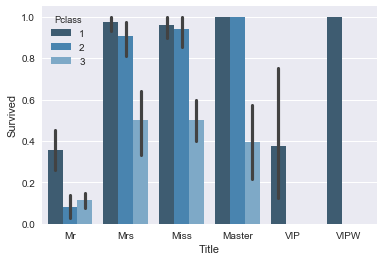

In [2241]:
ax = sns.barplot(x=comb['Title'][~comb['Survived'].isnull()], hue=comb['Pclass'], y=train['Survived'], palette='Blues_d')
plt.show()

Both 'VIP' and, to a lesser extent, 'Master', exhibit a high amount of variability.  This could be a problem, and I don't know yet whether I want to use Titles for classification. 

In [1790]:
comb[['Title']].groupby('Title')['Title'].count()

Title
Master     61
Miss      262
Mr        773
Mrs       200
VIP        10
VIPW        3
Name: Title, dtype: int64

The count of VIP is low, so the variability doesn't bother me.  But because Master is highly variable and its count is much higher, it will eventually be worth studying this category.

### 1.2. Processing ages

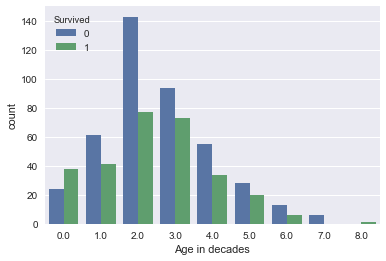

In [1858]:
ax = sns.countplot(x=comb['Age'][~comb['Survived'].isnull()].transform(lambda x:x // 10),  hue=train['Survived'])
ax.set(xlabel = 'Age in decades')
plt.show()

Age is tricky.  One striking thing about this is that when we divide ages by decade, the only age group in which survival chances are higher is 0-10, while those range 20-30 were more likely to die than survive. We might want to include categories to reflect this fact.

Many age values are missing, and some decades exhibit a large amount of variability in survival rates.  The most straightforward way to fill in the missing ages is to use linear regression.

In [1870]:
clf_age = svm.SVR(kernel='linear')
Age_full = comb[['SibSp','Parch','With_Family','Groups','Sex','Title','Pclass','Age']].copy()
y_age_train = Age_full[['Age']][~comb['Age'].isnull()]
Age_d = pd.get_dummies(data=Age_full, columns=['With_Family','Groups','Sex','Title','Pclass'])
Age_train = Age_d[~Age_d['Age'].isnull()].drop(columns=['Age'])
Age_test = Age_d[Age_d['Age'].isnull()].drop(columns=['Age'])

In [1871]:
clf_age.fit(Age_train, np.array(y_age_train).ravel())
age_pred = clf_age.predict(Age_test)

In [1904]:
miss_idx = np.where(comb['Age'].isnull())[0]
for i, d in enumerate(miss_idx):
    comb.loc[d, 'Age'] = age_pred[i]

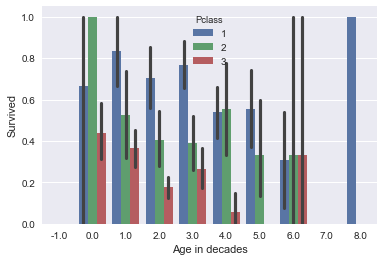

In [1908]:
ax = sns.barplot(x=comb['Age'][~comb['Survived'].isnull()].transform(lambda x:x // 10), hue=comb['Pclass'], y=train['Survived'])
ax.set(xlabel = 'Age in decades')
plt.show()

We make two categories: one for passengers 10 and under, and one for passengers aged 20-30.  You can also play around with whether or not you want to include other criteria. Including these two categories improved my final score.

In [2109]:
s = comb[['Pclass']].transform(lambda x: x == 1)
t = comb[['Age']].transform(lambda x: x <= 10)
comb['Child'] = s['Pclass'] & t['Age']

In [2180]:
col1 = comb[['Sex']].transform(lambda x: x == 'male')
col2 = comb[['Age']].transform(lambda x: (20 <= x) & (x <= 30))
comb['20to30'] = col1['Sex'] & col2['Age']

### 1.3. SibSp, Parch, and Shared tickets
Many families traveled on the same ticket.  Let's find all people traveling on shared tickets and evaluate their survival rates.

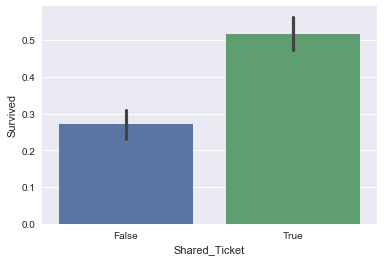

In [1503]:
comb['Shared_Ticket'] = comb.duplicated('Ticket', keep=False)
ax = sns.barplot(x=comb['Shared_Ticket'][~comb['Survived'].isnull()], y=train['Survived'])
plt.show()

Those on shared tickets were roughly twice as likely to survive.  It might make sense to combine SibSp, Parch, and Shared_Ticket into categories that reflect the sizes of traveling groups.  

In [1215]:
summed = comb['Parch']+comb['SibSp']+1
grouped = comb[['Ticket']].groupby('Ticket').size()
comb['Ticket_Count'] = np.array(grouped[comb['Ticket']])
comb['Group_Size'] = pd.concat([comb['Ticket_Count'], summed], axis=1).max(axis=1)

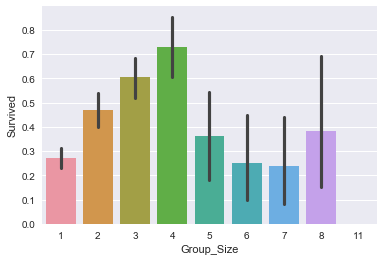

In [1216]:
ax = sns.barplot(x=comb['Group_Size'][~comb['Survived'].isnull()] , y=train['Survived'])
plt.show()

To me, there are four distinct groupings: those traveling in groups of size 1, size 2, size 3-4, and size 5+.

In [1659]:
def size_groups(x):
    if x == 1:
        return 1
    if x == 2:
        return 2
    if 3<= x <= 4:
        return 3
    else:
        return 4

In [1660]:
comb['Groups'] = comb['Group_Size'].transform(size_groups)

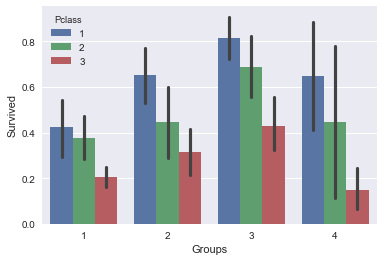

In [1661]:
ax = sns.barplot(x=comb['Groups'][~comb['Survived'].isnull()], hue=comb['Pclass'], y=train['Survived'])
plt.show()

The survival rates of 2nd class passengers in large groups has high variability.

Now that we've accounted for group size, perhaps special emphasis should be placed on family groups.  Let's make a column for it.

In [1405]:
def f(x):
    if x > 0:
        return True
    else:
        return False
col1 = comb['SibSp'].map(f)
col2 = comb['Parch'].map(f)
comb['With_Family'] = col1 | col2

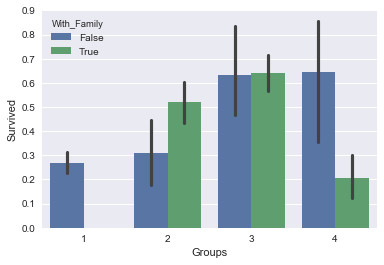

In [2165]:
ax = sns.barplot(x=comb['Groups'][~comb['Survived'].isnull()], hue=comb['With_Family'], y=train['Survived'])
plt.show()

### 1.4. Pclass, Embarked, and Fare

Pclass is not missing any values. 

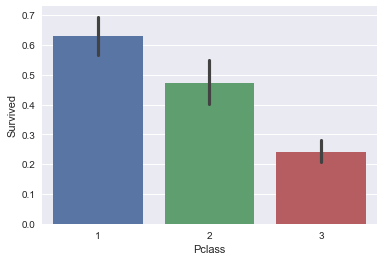

In [1054]:
ax = sns.barplot(x=comb['Pclass'][~comb['Survived'].isnull()], y=train['Survived'])
ax.set(xlabel = 'Pclass')
plt.show()

Clearly, those in 1st class were more likely to survive, and those in 3rd class were more likely to die; from popular knowledge of the disaster, this is not surprising.  2nd class is essentially a coin toss. 

For handling Fare and Embarked, I was influenced by Erik Bruin's excellent and detailed analysis:
https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting


Fare is missing a couple of values. and it also has some 0 values (?).  These 0 values might mess things up, so we should change them to match Pclass and Embarked. We compute the Fare Per Person using Ticket_Count.

In [1287]:
comb['FarePP'] = comb['Fare']/comb['Ticket_Count']

In [1266]:
grouped = comb[['FarePP','Embarked','Pclass']].groupby(['Embarked','Pclass']).median()
grouped

FarePP
Embarked Pclass         
C        1       34.6500
         2       13.8583
         3        7.2271
Q        1       30.0000
         2       12.3500
         3        7.7500
S        1       26.5500
         2       11.5000
         3        7.7958

With this, we fill in the missing Fare value.

In [1279]:
comb.loc[comb['PassengerId']==1044, 'Fare']= 7.7958

Now we tackle the missing Embarked values.

In [1219]:
comb.query('Embarked != Embarked')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Shared_Ticket,Group_Size,Groups,No_Cabin,FarePP,Ticket_count,Ticket_Count
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,True,2,2,False,40.0,2,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,True,2,2,False,40.0,2,2


Based on the FarePP and Pclass, they probably boarded at Cherbourg.

In [1281]:
comb.loc[comb['PassengerId']==62, 'Embarked']='C'
comb.loc[comb['PassengerId']==830,'Embarked']='C'

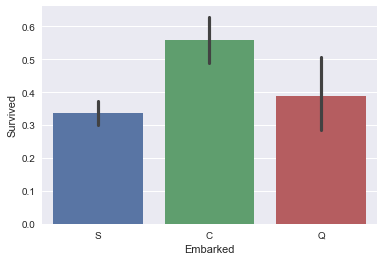

In [1282]:
ax = sns.barplot(x=comb['Embarked'][~comb['Survived'].isnull()], y=train['Survived'])
ax.set(xlabel = 'Embarked')
plt.show()

It's not clear if Embarked is important or not.

Now to handle missing FarePP values.  The missing values, and the values currently set to 0, will be set to the median relative to Embarked and Pclass.

In [1267]:
comb.query('(Fare != Fare) | (Fare == 0)')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Shared_Ticket,Group_Size,Groups,No_Cabin,FarePP,Ticket_Count
179,36.0,NaN,S,0.0,"Leonard, Mr. Lionel",0,180,3,male,0,0.0,LINE,Mr,True,4,4,True,0.0,4
263,40.0,B94,S,0.0,"Harrison, Mr. William",0,264,1,male,0,0.0,112059,Mr,False,1,1,False,0.0,1
271,25.0,NaN,S,0.0,"Tornquist, Mr. William Henry",0,272,3,male,0,1.0,LINE,Mr,True,4,4,True,0.0,4
277,NaN,NaN,S,0.0,"Parkes, Mr. Francis ""Frank""",0,278,2,male,0,0.0,239853,Mr,True,3,3,True,0.0,3
302,19.0,NaN,S,0.0,"Johnson, Mr. William Cahoone Jr",0,303,3,male,0,0.0,LINE,Mr,True,4,4,True,0.0,4
413,NaN,NaN,S,0.0,"Cunningham, Mr. Alfred Fleming",0,414,2,male,0,0.0,239853,Mr,True,3,3,True,0.0,3
466,NaN,NaN,S,0.0,"Campbell, Mr. William",0,467,2,male,0,0.0,239853,Mr,True,3,3,True,0.0,3
481,NaN,NaN,S,0.0,"Frost, Mr. Anthony Wood ""Archie""",0,482,2,male,0,0.0,239854,Mr,False,1,1,True,0.0,1
597,49.0,NaN,S,0.0,"Johnson, Mr. Alfred",0,598,3,male,0,0.0,LINE,Mr,True,4,4,True,0.0,4
633,NaN,NaN,S,0.0,"Parr, Mr. William Henry Marsh",0,634,1,male,0,0.0,112052,Mr,False,1,1,True,0.0,1


Interestingly, they all boared in Southampton.  That makes filling in their ages with the median over each Pclass easier.

In [1232]:
grouped = comb[['FarePP','Pclass','Embarked']][comb['Embarked']=='S'].groupby(['Pclass']).median()
grouped

,FarePP
Pclass,
1,26.5500
2,11.5000
3,7.7958


In [1290]:
comb['FarePP'] = comb[['FarePP']].replace({0.0:np.nan})

In [1293]:
comb['FarePP'] = comb.groupby(['Embarked','Pclass'])['FarePP'].transform(lambda x:x.fillna(x.median()))

### 1.5. Consecutive tickets and alternative names

There are interesting groups of consecutive ticket numbers that suggest some passengers may have been traveling with relatives not captured by shared tickets, SibSp or Parch. Like the groups above, it would be nice to incorporate this.  Yet I'm not convinced that all such consecutive grouping actually indicate several people traveling together.

Maiden/alternative names can be extracted from the passenger list as follows:

In [ ]:
grouped = comb['Name'].groupby([comb['Name'].str.contains('\(')])
def l_name(s):
    l = s.split(' ')
    return l[len(l)-1]
h = lambda x:l_name(x[x.find("(")+1:x.find(")")+1].strip('\"\(\)'))
g = lambda s: s.apply(h)
transform = grouped.transform(g)
comb['Other_Name'] = transform

With this, one might try to find hidden groups of travelers. This assumes some relation between the maiden/alternative names and other Names. The following family illustrates that these hidden relations exist but are not straightforward to determine.

In [2158]:
comb[comb['Name'].str.contains('Andersson')][['PassengerId','Name','Pclass','Parch','SibSp','Age','Ticket','Groups','Embarked']]

,PassengerId,Name,Pclass,Parch,SibSp,Age,Ticket,Groups,Embarked
13,14,"Andersson, Mr. Anders Johan",3,5,1,39.0,347082,4,S
68,69,"Andersson, Miss. Erna Alexandra",3,2,4,17.0,3101281,4,S
119,120,"Andersson, Miss. Ellis Anna Maria",3,2,4,2.0,347082,4,S
146,147,"Andersson, Mr. August Edvard (""Wennerstrom"")",3,0,0,27.0,350043,1,S
541,542,"Andersson, Miss. Ingeborg Constanzia",3,2,4,9.0,347082,4,S
542,543,"Andersson, Miss. Sigrid Elisabeth",3,2,4,11.0,347082,4,S
610,611,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",3,5,1,39.0,347082,4,S
813,814,"Andersson, Miss. Ebba Iris Alfrida",3,2,4,6.0,347082,4,S
850,851,"Andersson, Master. Sigvard Harald Elias",3,2,4,4.0,347082,4,S
981,982,"Dyker, Mrs. Adolf Fredrik (Anna Elisabeth Judi...",3,0,1,22.0,347072,2,S


Many have been placed correctly into Group 4 (indicating they traveled with 5+ people). But two stand out as possibly wrong. Was Anna Elizabeth Dyker traveling in a larger group?  Her maiden name matches others in this group and her ticket number is close as well. If so, she should be included in a much larger group.  Similarly, Johan Samuel Anderrson is marked as a solo traveler, but he should be included in the larger group. 

This suggests that if two passengers have significant overlap in name, and have very close ticket numbers, they were likely traveling together.  

Fixing the group sizes is something I intend to do in the future.

### 1.6. Cabin number

A lot of cabin data is either missing.  Does this mean the information is not available, or that most people weren't assigned a cabin?  I don't know. 

In [1063]:
comb['No_Cabin'] = pd.isna(comb['Cabin'])

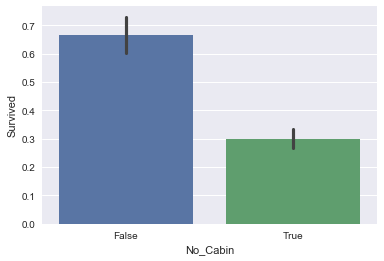

In [1064]:
ax = sns.barplot(x=comb['No_Cabin'][~comb['Survived'].isnull()], y=train['Survived'])
plt.show()

If you had a cabin, you were more than twice as likely to survive.  Yet this is certainly overlapping with Pclass, and a lot of cabin information could be missing.  We may not use this.

## 2. Fitting a model

We will fit with three different classifiers, then use a voting system for the final prediction.  

### 2.1. Predictors

Our predictors are: Sex, Child, 20to30, Groups, Pclass, With_Family, and FarePP.

In [2203]:
cols = ['20to30','Child','Sex','Pclass','With_Family']
comb_d = pd.get_dummies(data=comb[['With_Family','20to30','FarePP','Child','Survived','PassengerId','Sex','Pclass','Groups']], columns=cols)
X = comb_d[comb_d['PassengerId']<=891]
y = X['Survived']
X_test = comb_d[comb_d['PassengerId']>891]
X = X.drop(['Survived','PassengerId'],axis=1)
X_test = X_test.drop(['Survived','PassengerId'],axis=1)

### 2.2. Tuning SVM parameters

We employ GridSearchCV to find the best estimator for SVM.

In [1127]:
param_grid={'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1], 'C': [1, 10, 50, 100, 200, 300, 1000], 'decision_function_shape': ['ovo', 'ovr']}

In [2204]:
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1], 'C': [1, 10, 50, 100, 200, 300, 1000], 'decision_function_shape': ['ovo', 'ovr']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [2205]:
clf.best_estimator_

SVC(C=300, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [2206]:
clf_svc = svm.SVC(C=300, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
scores = cross_val_score(clf_svc, X, y, cv=5)
print("Mean: {0} +- {1}".format(scores.mean(), 2*scores.std()))

Mean: 0.8103927708014826 +- 0.03505947445643813


This looks pretty good. While the mean is not high --- and with other predictors I can make the mean higher --- the deviation is relatively low. 

### 2.3. Random Forests and Gradient Boosting

I don't want to stick to just one model. 

In [1433]:
clf_rfc = RandomForestClassifier()
clf_gbc = GradientBoostingClassifier()

In [2207]:
scores = cross_val_score(clf_rfc, X, y, cv=5)
print("Mean: {0} +- {1}".format(scores.mean(), 2*scores.std()))

Mean: 0.8103548246729275 +- 0.020605603019371112


In [2208]:
scores = cross_val_score(clf_gbc, X, y, cv=5)
print("Mean: {0} +- {1}".format(scores.mean(), 2*scores.std()))

Mean: 0.8204548428657908 +- 0.028550801326065314


I like these three scores for their low deviation.

In [2187]:
clf_svc.fit(X,y)
clf_rfc.fit(X,y)
clf_gbc.fit(X,y)
pred_svc = clf_svc.predict(X_test)
pred_rfc = clf_rfc.predict(X_test)
pred_gbc = clf_gbc.predict(X_test)

### 2.4. Model correlation

Let's look at the correlation between them.

In [2210]:
corr_df = pd.DataFrame({'SVC':pred_svc, 'RFC':pred_rfc, 'GBC':pred_gbc})

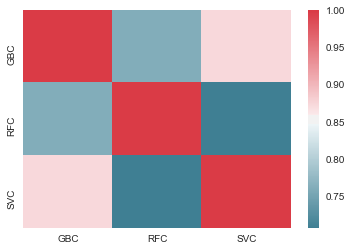

In [2230]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(corr_df.corr(), cmap=cmap )
plt.show()

This isn't spectacular and suggests there is room for improvement.

### 2.5. Model voting

Though it's not obvious from above, SVM seems to consistently do the best.  We make our prediction based on SVM, unless overruled by an agreement among the other two classifiers.

In [2188]:
final_pred = []
for i in range(len(pred_svc)):
    if pred_rfc[i] != pred_gbc[i]:
        final_pred.append(pred_svc[i])
    else:
        final_pred.append(pred_rfc[i])

In [2195]:
with open('titanic_pred_041118.csv','w') as f:
    f.write('PassengerId,Survived\n')
    for i in range(len(final_pred)):
        f.write(str(comb['PassengerId'].iloc[i+891])+','+str(int(final_pred[i]))+'\n')

## 3. Conclusions

This analysis scored above 0.8 on Kaggle, which as of this writing is the top 11%.  I'm pleased with the result, but there is room for improvement. Specific areas that could be improved are:

1. Traveling groups should be modified to incorporate maiden/alternative names and close ticket numbers.
2. Age reward/penalties could stand a more detailed analysis.  These rewards/penalties improved my overall score, but I think I can do better.
3. The correlation among the various models is higher than I would like.  I want to either incorporate more models and modify the voting procedure, or replace Gradient Boosting with a different classifier.